In [1]:
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastprop
import os
from rdkit import Chem
import scipy
from matplotlib import cm
from matplotlib.colors import Normalize 
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from pathlib import Path
from matplotlib_venn import venn2
from matplotlib_venn import venn2_circles
import polars as pl
import matplotlib.image as mpimg
import matplotlib.transforms as mtransforms
from rdkit import Chem
from rdkit.Chem import Draw

matplotlib.rcParams.update({'font.style': 'normal'})
matplotlib.rcParams.update({'font.sans-serif': 'Segoe UI'})
matplotlib.rcParams.update({'font.size': 26})

colors = sns.color_palette(palette='Accent').as_hex()


In [2]:
def stats(true, predicted): 
    mse = mean_squared_error(true, predicted)

    differences = np.abs(true - predicted)
    within_1_unit = differences <= 1
    percentage_within_1_unit = np.sum(within_1_unit) / len(true) * 100
    return mse, percentage_within_1_unit

Fastprop Krasnov performance

In [3]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\old_results\final_results\final_results", "fastprop")
training_performance: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "bigsoldb_downsample_predictions.csv"))
mse_training, percentage_within_1_unit_training = stats(training_performance['logS_true'], training_performance['logS_pred'])
print("MSE Krasnov training= " + f"{np.sqrt(mse_training)}", 
      "\nPercentage within 1 logS for Training = " + f"{percentage_within_1_unit_training}")

MSE Krasnov training= 0.7014462549433815 
Percentage within 1 logS for Training = 87.53126269211859


Label distributions

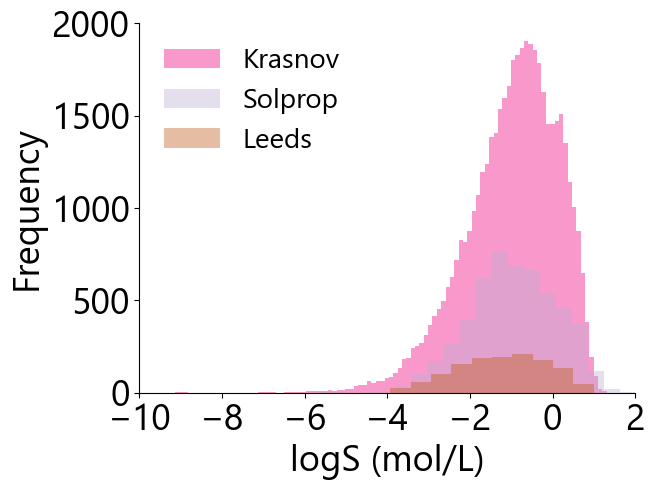

In [4]:
_src_dir: str = os.path.join(r"C:\Users\ChemeGrad2021\Documents\highsol\final_results", "fastprop_5215_predictions")
solprop: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "solprop_fastprop_nonaq_predictions.csv"))
training_performance['logS_true'].plot(kind='hist', bins=120, color = colors[5], alpha = 0.4, label = 'Krasnov')
solprop['logS_true'].plot(kind='hist', bins=20, alpha = 0.4, color = colors[1], label = 'Solprop')

leeds_acetone: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_acetone_fastprop_predictions.csv"))
leeds_benzene: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_benzene_fastprop_predictions.csv"))
leeds_ethanol: pd.DataFrame = pd.read_csv(os.path.join(_src_dir, "leeds_ethanol_fastprop_predictions.csv"))
leeds_all = pd.concat([leeds_acetone, leeds_benzene, leeds_ethanol], ignore_index=True, axis=0) 
leeds_all['logS_true'].plot(kind='hist', bins=10, alpha = 0.4, color = colors[6], label = 'Leeds')

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("logS (mol/L)")
plt.xlim([-10, 2])
plt.xticks([-10, -8, -6, -4, -2, 0, 2 ])
plt.legend(prop={'size': 20}, loc = 'upper left', frameon = False) 
#plt.ylim([-10, 1200])
#plt.yticks([0, 400, 800, 1200])

Venn Diagram of solute overlap

In [5]:
training_performance[['solvent', 'solute']] = training_performance['smiles'].str.split('.', expand=True)
unique_solutes_krasnov = set(Chem.CanonSmiles(s) for s in training_performance["solute"])
print(len(unique_solutes_krasnov))

solprop[['solvent', 'solute']] = solprop['smiles'].str.split('.', expand=True, n=1)
unique_solutes_solprop = set(Chem.CanonSmiles(s) for s in solprop["solute"])
print(len(unique_solutes_solprop))

leeds_all[['solvent', 'solute']] = leeds_all['smiles'].str.split('.', expand=True)
unique_solutes_leeds = set(Chem.CanonSmiles(s) for s in leeds_all["solute"])
print(len(unique_solutes_leeds))

704
101
1018


In [6]:
vermeire_training_solutes = []
vermeire_training_solvents = []
for training_set in (
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\AqueousSolu.csv"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolv-Exp.csv"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolv-QM.txt"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolvH-Exp.csv"),
    Path(r"C:\Users\ChemeGrad2021\Documents\highsol\data\SolProp_v1.2\Data\CombiSolvH-QM.txt"),
):
    if training_set.suffix == "xlsx":
        df = pd.read_excel(training_set)
    else:
        df = pd.read_csv(training_set)
    if "Aqueous" in training_set.name:
        vermeire_training_solutes.extend(df["smiles solute"])
    elif "QM" in training_set.name:
        vermeire_training_solutes.extend(df["smiles solute"])
        vermeire_training_solvents.extend(df["smiles solvent"])
    else:
        vermeire_training_solutes.extend(df["smiles_solute"])
        vermeire_training_solvents.extend(df["smiles_solvent"])

# cast to set twice - once to remove immediate dupes, again to remove
# multiple identical representations
vermeire_training_solvents = set(Chem.CanonSmiles(s) for s in set(vermeire_training_solvents))
vermeire_training_solutes = set(Chem.CanonSmiles(s) for s in set(vermeire_training_solutes))
print(f"Vemeire training data includes {len(vermeire_training_solvents):d} solvents and {len(vermeire_training_solutes):d} solutes.")

[14:19:09] WARNING: not removing hydrogen atom without neighbors


Vemeire training data includes 1536 solvents and 20486 solutes.


In [7]:
solprop[['solvent', 'solute']] = solprop['smiles'].str.split('.', expand=True, n=1)
vermeire_testing_solutes = set(Chem.CanonSmiles(s) for s in solprop["solute"])
vermeire_testing_solvents = set(Chem.CanonSmiles(s) for s in solprop["solute"])
print(f"Solprop testing data includes {len(vermeire_testing_solvents):d} solvents and {len(vermeire_testing_solutes):d} solutes.")

Solprop testing data includes 101 solvents and 101 solutes.


In [8]:
unique_solutes_solprop_training = set(np.array(list(vermeire_training_solutes)).flatten())
unique_solutes_solprop = set(np.array(list(vermeire_testing_solutes)).flatten())


overlapping_solutes = unique_solutes_krasnov.intersection(unique_solutes_leeds)

print(f"Overlap of Krasnov and Leeds solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_leeds):.2%} of test set.")

overlapping_solutes = unique_solutes_leeds.intersection(unique_solutes_solprop_training)
print(f"Overlap of Solprop training and Leeds solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_leeds):.2%} of test set.")

overlapping_solutes = unique_solutes_krasnov.intersection(unique_solutes_solprop_training)
print(f"Overlap of Solprop training and Krasnov solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_solprop_training):.2%} of test set.")

overlapping_solutes = unique_solutes_krasnov.intersection(unique_solutes_solprop)
print(f"Overlap of Solprop testing and Krasnov solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_solprop):.2%} of test set.")

overlapping_solutes = unique_solutes_solprop_training.intersection(unique_solutes_solprop)
print(f"Overlap of Solprop training and Solprop testing solutes is {len(overlapping_solutes):d}, or {len(overlapping_solutes)/len(unique_solutes_solprop):.2%} of test set.")

Overlap of Krasnov and Leeds solutes is 25, or 2.46% of test set.
Overlap of Solprop training and Leeds solutes is 341, or 33.50% of test set.
Overlap of Solprop training and Krasnov solutes is 353, or 1.72% of test set.
Overlap of Solprop testing and Krasnov solutes is 61, or 60.40% of test set.
Overlap of Solprop training and Solprop testing solutes is 77, or 76.24% of test set.


In [9]:
colors

['#7fc97f',
 '#beaed4',
 '#fdc086',
 '#ffff99',
 '#386cb0',
 '#f0027f',
 '#bf5b17',
 '#666666']

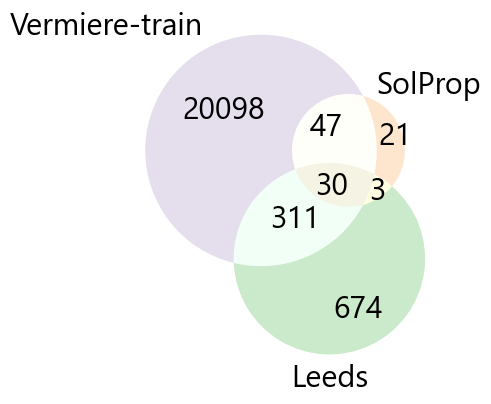

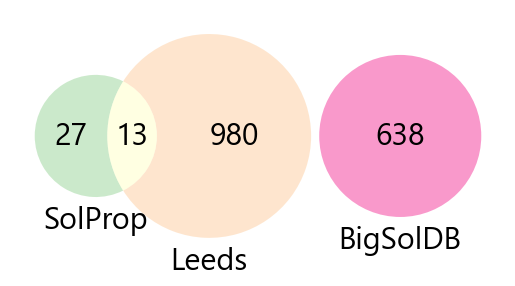

In [10]:
from matplotlib_venn import venn3, venn3_unweighted, venn3_circles

vermiere_venn = venn3_unweighted(
    [unique_solutes_solprop_training, unique_solutes_solprop, unique_solutes_leeds],
    ("Vermiere-train", "SolProp", "Leeds"),
    subset_areas = (1000, 4*10, 23*10, 675, 309, 50, 60),
    set_colors = (colors[1], colors[2], colors[0]),
    # first set, second set, overlap 1/2, 3rd, overlap 1/3, overlap 2/3, total overlap
)
#venn3_circles((1000, 4*10, 23*10, 675, 309, 50, 60))

for set_label in vermiere_venn.set_labels:
    if set_label:  # Check if the label exists
        set_label.set_fontsize(22)  # Set the desired font size

# Change the font size of the subset labels (numbers in the Venn diagram regions)
for subset_label in vermiere_venn.subset_labels:
    if subset_label:  # Check if the label exists
        subset_label.set_fontsize(22)  # Set the desired font size

plt.show()

our_venn = venn3_unweighted(
    [unique_solutes_krasnov, vermeire_testing_solutes, unique_solutes_leeds],
    ("BigSolDB", "SolProp", "Leeds"),
    subset_areas=(704, 270, 0, 984, 0, 130, 0),
    # (Abc, aBc, ABc, abC, AbC, aBC, ABC)
    set_colors = (colors[5], colors[0], colors[2]),
    alpha = 0.4,
)
# venn3_circles([set(unique_solutes_krasnov), set(unique_solutes_leeds), set(unique_solutes_solprop)], linewidth=2)


for set_label in our_venn.set_labels:
    if set_label:  # Check if the label exists
        set_label.set_fontsize(22)  # Set the desired font size

# Change the font size of the subset labels (numbers in the Venn diagram regions)
for subset_label in our_venn.subset_labels:
    if subset_label:  # Check if the label exists
        subset_label.set_fontsize(22)  # Set the desired font size


plt.show()

Plotting all together for Figure 1

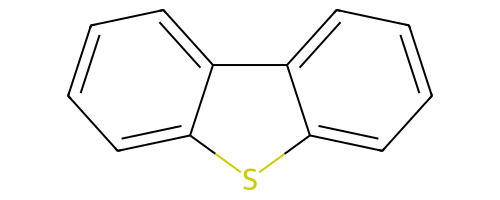

In [59]:
df = pl.read_csv(Path("../data/krasnov/bigsoldb_downsample.csv"), columns=["solute_smiles", "solvent_smiles", "logS", "temperature", "source"]).to_pandas()
df = df.groupby(["source", "solvent_smiles", "solute_smiles"])[["logS", "temperature"]].aggregate(list)

row_i = ('10.1016/j.jct.2018.09.017', 'OCCOCCO', 'c1ccc2c(c1)sc1ccccc12')
row_j = ('10.1016/j.jct.2020.106234', 'OCCOCCO', 'O=C(O)c1ccccc1')
logS_i, temperature_i = df.loc[row_i]
logS_j, temperature_j = df.loc[row_j]
img = Draw.MolToImage(Chem.MolFromSmiles(row_i[2]), size=(500, 200))
img
#width, length = img.size


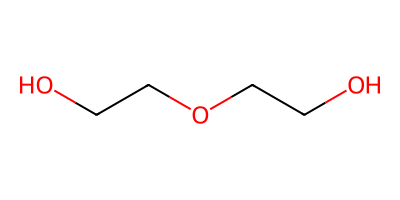

In [60]:
img = Draw.MolToImage(Chem.MolFromSmiles(row_i[1]), size=(400, 200))
img

<Figure size 640x480 with 0 Axes>

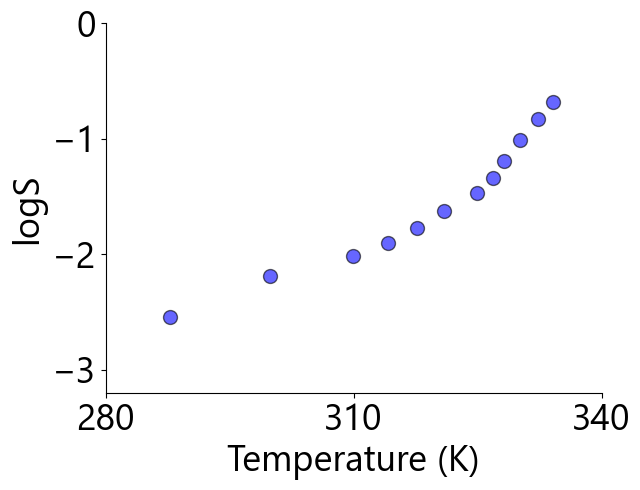

In [61]:
plt.figure(figsize=[6.4,4.8])
fig, ax1 = plt.subplots()


ax1.plot(temperature_i, logS_i, color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='Train')
ax1.set_xlabel("Temperature (K)")
ax1.set_ylabel("logS")
ax1.set_xticks([280, 310, 340])
ax1.set_ylim([-3.2, 0])
#ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
ax1.spines[['right', 'top']].set_visible(False)

#ax1.text(304, 1, 'Solute')
#ax1.set_title("Solute", color='b')

plt.show()


In [51]:
colors[2]
colors[0]

'#7fc97f'

C:\Users\ChemeGrad2021\AppData\Local\Temp\ipykernel_38196\4254168689.py:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  h_parity.set_yticklabels([-8, -6, -4, -2, 0, 2])


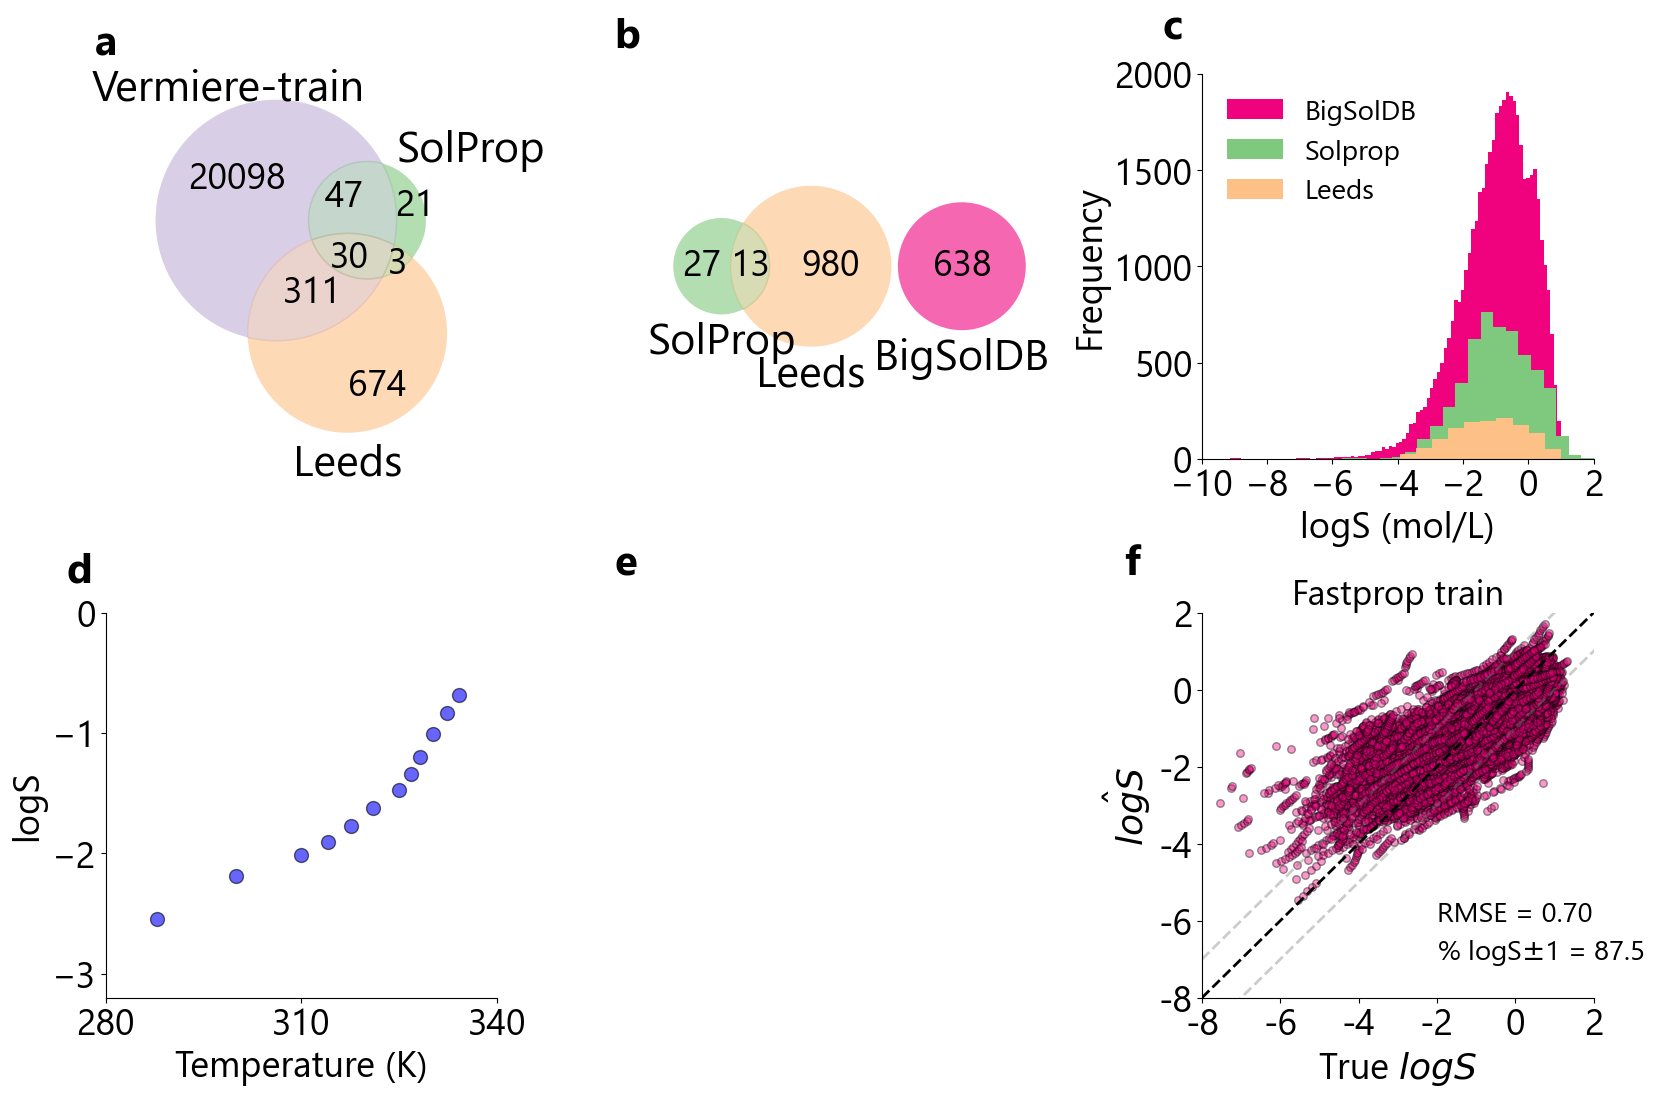

In [63]:
fig = plt.figure(figsize=(6.4*3, 4.8*2.5))  # Adjust the figure size 

# Top row: Venn diagrams and histogram
a_fastsolv_solutes = plt.subplot2grid(shape=(2, 3), loc=(0, 0), colspan=1)
vermiere_venn = venn3_unweighted(
    [unique_solutes_solprop_training, unique_solutes_solprop, unique_solutes_leeds],
    ("Vermiere-train", "SolProp", "Leeds"),
    subset_areas=(1000, 4*10, 23*10, 675, 309, 50, 60),
    set_colors=(colors[1], colors[0], colors[2]),
    alpha = 0.6
)
vermiere_venn.get_patch_by_id('110').set_color('#9FBCAA')  # Overlap between Vermiere-train and SolProp
vermiere_venn.get_patch_by_id('101').set_color('#DEB7AD')  # Overlap between Vermiere-train and Leeds
vermiere_venn.get_patch_by_id('011').set_color('#BEC583')             # overlap between Solprop and leeds
vermiere_venn.get_patch_by_id('111').set_color('#bebd9e') # overlap between all



# Adjust the position of the Venn labels to move them inside the plot
vermiere_venn.get_label_by_id("A").set_position((0.2, 0.62))  # Manually adjust position

a_fastsolv_solutes.text(-0.1, 1.05, "a", weight='bold', fontsize=30, transform=a_fastsolv_solutes.transAxes)  # Adjusted panel label position

b_venn = plt.subplot2grid(shape=(2, 3), loc=(0, 1), colspan=1)
our_venn = venn3_unweighted(
    [unique_solutes_krasnov, vermeire_testing_solutes, unique_solutes_leeds],
    ("BigSolDB", "SolProp", "Leeds"),
    subset_areas=(704, 270, 0, 984, 0, 130, 0),
    set_colors=(colors[5], colors[0], colors[2]),
    alpha = 0.6
)
our_venn.get_patch_by_id('011').set_color('#BEC583')

# Raised the panel label for "e" slightly higher
b_venn.text(-0.1, 1.6, "b", weight='bold', fontsize=30, transform=b_venn.transAxes)  # Adjusted panel label position

e_hist = plt.subplot2grid(shape=(2, 3), loc=(0, 2), colspan=1)
training_performance['logS_true'].plot(kind='hist', bins=120, color=colors[5], label='BigSolDB', ax=e_hist)
solprop['logS_true'].plot(kind='hist', bins=20, color=colors[0], label='Solprop', ax=e_hist)
leeds_all['logS_true'].plot(kind='hist', bins=10, color=colors[2], label='Leeds', ax=e_hist)
e_hist.spines[['top', 'right']].set_visible(False)
e_hist.set_xlabel("logS (mol/L)")
e_hist.set_xlim([-10, 2])
e_hist.set_xticks([-10, -8, -6, -4, -2, 0, 2])
e_hist.legend(prop={'size': 20}, loc='upper left', frameon=False)
e_hist.text(-0.1, 1.09, "c", weight='bold', fontsize=30, transform=e_hist.transAxes)  # Adjusted panel label position

# Bottom ror
f_panel = plt.subplot2grid(shape=(2, 3), loc=(1, 0), colspan=1)

f_panel.text(-0.1, 1.08, "d", weight='bold', fontsize=30, transform=f_panel.transAxes)  # Adjusted panel label position
row_i = ('10.1016/j.jct.2018.09.017', 'OCCOCCO', 'c1ccc2c(c1)sc1ccccc12')
row_j = ('10.1016/j.jct.2020.106234', 'OCCOCCO', 'O=C(O)c1ccccc1')
logS_i, temperature_i = df.loc[row_i]
logS_j, temperature_j = df.loc[row_j]

f_panel.plot(temperature_i, logS_i, color='b', marker = 'o', markersize = 10, linestyle = 'none', markeredgecolor = 'black', alpha = 0.6, label='Train')
f_panel.set_xlabel("Temperature (K)")
f_panel.set_ylabel("logS")
f_panel.set_xticks([280, 310, 340])
f_panel.set_ylim([-3.2, 0])
#ax1.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
f_panel.spines[['right', 'top']].set_visible(False)

g_panel = plt.subplot2grid(shape=(2, 3), loc=(1, 1), colspan=1)
g_panel.axis('off')
g_panel.text(-0.1, 1.1, "e", weight='bold', fontsize=30, transform=g_panel.transAxes)  # Adjusted panel label position

h_parity = plt.subplot2grid(shape=(2, 3), loc=(1, 2), colspan=1)
h_parity.plot([-8, 8], [-8,8], linestyle = '--', linewidth = 2, color = 'black')
h_parity.plot([-8, 8], [-9,7], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
h_parity.plot([-8, 8], [-7,9], linestyle = '--', linewidth = 2, color = 'gray', alpha = 0.4)
h_parity.scatter(training_performance['logS_true'],training_performance['logS_pred'], alpha =0.4, s = 30, edgecolors = 'black', color = colors[5])

h_parity.set_xlim([-8, 2])
h_parity.set_xticks([-8, -6, -4, -2, 0, 2])
h_parity.set_xticklabels([-8, -6, -4, -2, 0, 2])
h_parity.set_ylim([-8,2])
h_parity.set_yticklabels([-8, -6, -4, -2, 0, 2])

h_parity.set_ylabel(r"$\hat{logS}$")
h_parity.set_xlabel(r"True $logS$")
#ax4.legend(prop={'size': 20}, loc = 'upper left', frameon = False, bbox_to_anchor=(-0.05,1.1)) 
h_parity.spines[['right', 'top']].set_visible(False)
h_parity.text(-2,-6, f"RMSE = {np.sqrt(mse_training):.2f}", fontsize = 20)
h_parity.text(-2,-7, '% logS' + r'$\pm$'  + f"1 = {percentage_within_1_unit_training:.1f}", fontsize = 20)
h_parity.set_title("Fastprop train", fontsize = 25)
# Move the panel label "i" outside and aligned at the top
h_parity.text(-0.2, 1.1, "f", weight='bold', fontsize=30, transform=h_parity.transAxes)  # Moved label outside and higher

# Adjust layout
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()
